# Noisy Bilocal Network Optimization

In this notebook, we optimize quantum non-bilocality in the presence of noise.
The bilocal network consists of three measurement nodes that connected in a line by two preparation nodes.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import qnetvo as qnet

In [2]:
prep_nodes = [
    qnet.PrepareNode(1, [0,1], qml.ArbitraryStatePreparation, 6),
    qnet.PrepareNode(1, [2,3], qml.ArbitraryStatePreparation, 6),
]
meas_nodes = [
    qnet.MeasureNode(2, 2, [0], qml.ArbitraryUnitary, 3),
    qnet.MeasureNode(2, 2, [1,2], qml.ArbitraryUnitary, 15),
    qnet.MeasureNode(2, 2, [3], qml.ArbitraryUnitary, 3),
]

def pure_qubit_noise_nodes(fn, noise_param):
    return [qnet.NoiseNode([i, i+4], lambda settings, wires: fn(noise_param, wires=wires)) for i in range(4)]

def mixed_qubit_noise_nodes(fn, noise_params):
    return [qnet.NoiseNode([i], lambda settings, wires: fn(*noise_params[i], wires=wires[0])) for i in range(4)]

## Optimizing Bilocal Chains with Uniform Qubit Channel Noise

In this section, we optimize non-bilocality for the Bilocal Chain with different qubit noise channels.
The same noise is applied to each qubit independently. 

## Bilocal Uniform Qubit Depolarizing Noise

We use the PennyLane `"default.mixed"` simulator to apply a depolarizing channel to each qubit.
This simulator uses density matrix operations and is significantly slower than the `"default.qubit"` device which uses a state vector simulation.

In [3]:
%%time

depolarized_bilocal_opt_dicts = []

for gamma in np.arange(0,0.121,0.03):
    print("gamma : ", gamma)
    noise_nodes = mixed_qubit_noise_nodes(qml.DepolarizingChannel, [[gamma]]*4)
    depolarized_bilocal_ansatz = qnet.NetworkAnsatz(prep_nodes, noise_nodes, meas_nodes, dev_kwargs={"name": "default.mixed"})
    depolarized_bilocal_cost = qnet.nlocal_chain_22_cost_fn(depolarized_bilocal_ansatz)
    
    np.random.seed(1)
    depolarized_bilocal_settings = depolarized_bilocal_ansatz.rand_network_settings()

    depolarized_bilocal_opt_dict = qnet.gradient_descent(
        depolarized_bilocal_cost,
        depolarized_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    depolarized_bilocal_opt_dicts.append(depolarized_bilocal_opt_dict)
    
    print("max score : ", depolarized_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.6077670691442938
elapsed time :  0.6398129463195801
iteration :  3 , score :  1.250961928317058
elapsed time :  0.6407341957092285
iteration :  6 , score :  1.3566424077495944
elapsed time :  0.7174849510192871
iteration :  9 , score :  1.3924566501646267
elapsed time :  0.6724488735198975
iteration :  12 , score :  1.4042126164387452
elapsed time :  0.7297852039337158
max score :  1.408878406945897
gamma :  0.03
iteration :  0 , score :  0.5573187223446369
elapsed time :  0.6941511631011963
iteration :  3 , score :  1.1392775225170029
elapsed time :  0.722412109375
iteration :  6 , score :  1.2397771411077394
elapsed time :  0.6857469081878662
iteration :  9 , score :  1.2779716467380777
elapsed time :  0.6887741088867188
iteration :  12 , score :  1.2915645789022447
elapsed time :  0.6296248435974121
max score :  1.2970107726045579
gamma :  0.06
iteration :  0 , score :  0.509027677026721
elapsed time :  0.6682100296020508
iteration :  3 , sco

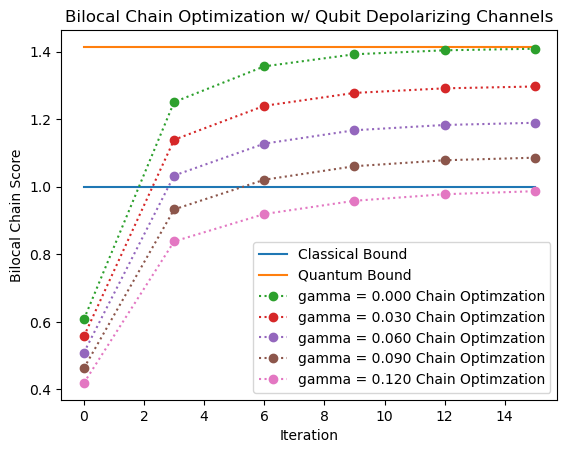

In [4]:
samples = depolarized_bilocal_opt_dicts[0]["samples"]

plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2/np.sqrt(2)]*len(samples), label = "Quantum Bound")

id = 0
gammas = np.arange(0,0.121,0.03)
for opt_dict in depolarized_bilocal_opt_dicts:
    plt.plot(samples, opt_dict["scores"], "o:", label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.title(r"Bilocal Chain Optimization w/ Qubit Depolarizing Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Score")
plt.legend()
plt.show()

## Bilocal Uniform Amplitude Damping Optimization

Amplitude damping noise can be implemented on a quantum circuit with one ancilla.
The circuit implementation is compatible with the `"default.qubit"` simulator in PennyLane
significantlly improving optimization performance.

In [5]:
%%time

ampdamp_bilocal_opt_dicts = []

for gamma in np.arange(0,0.241,0.06):
    print("gamma : ", gamma)
    ampdamp_nodes = pure_qubit_noise_nodes(qnet.pure_amplitude_damping, [gamma])
    ampdamp_bilocal_ansatz = qnet.NetworkAnsatz(
        prep_nodes,
        ampdamp_nodes,
        meas_nodes,
        dev_kwargs={"name" : "default.qubit"} # override the default.mixed simulator
    )
    ampdamp_bilocal_cost = qnet.nlocal_chain_22_cost_fn(ampdamp_bilocal_ansatz)
    
    np.random.seed(1)
    ampdamp_bilocal_settings = ampdamp_bilocal_ansatz.rand_network_settings()

    ampdamp_bilocal_opt_dict = qnet.gradient_descent(
        ampdamp_bilocal_cost,
        ampdamp_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    ampdamp_bilocal_opt_dicts.append(ampdamp_bilocal_opt_dict)
    
    print("max score : ", ampdamp_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.6077670691442973
elapsed time :  0.5368618965148926
iteration :  3 , score :  1.2509619283170585
elapsed time :  0.503382682800293
iteration :  6 , score :  1.3566424077495949
elapsed time :  0.5512430667877197
iteration :  9 , score :  1.3924566501646267
elapsed time :  0.674025297164917
iteration :  12 , score :  1.4042126164387447
elapsed time :  0.7003929615020752
max score :  1.4088784069458975
gamma :  0.06
iteration :  0 , score :  0.5902731894624238
elapsed time :  0.5659761428833008
iteration :  3 , score :  1.161543730832491
elapsed time :  0.6017231941223145
iteration :  6 , score :  1.2498453429479315
elapsed time :  0.6431469917297363
iteration :  9 , score :  1.2837543086866492
elapsed time :  0.6947071552276611
iteration :  12 , score :  1.2967614664455707
elapsed time :  0.7234048843383789
max score :  1.3022624038315422
gamma :  0.12
iteration :  0 , score :  0.57108855809638
elapsed time :  0.763124942779541
iteration :  3 , sc

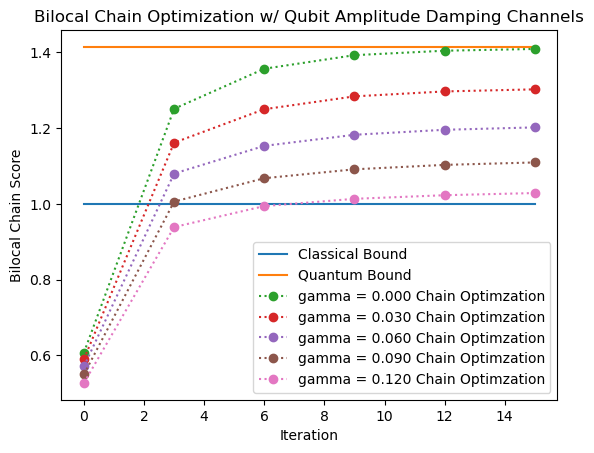

In [6]:
samples = ampdamp_bilocal_opt_dicts[0]["samples"]

plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2/np.sqrt(2)]*len(samples), label = "Quantum Bound")

id = 0
gammas = np.arange(0,0.121,0.03)
for opt_dict in ampdamp_bilocal_opt_dicts:
    plt.plot(samples, opt_dict["scores"], "o:", label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.title(r"Bilocal Chain Optimization w/ Qubit Amplitude Damping Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Score")
plt.legend()
plt.show()

## Bilocal Uniform Phase Damping Noise Optimization

Qubit Phase damping noise can also be implemented using a single ancillary qubit.
Hence we use the `"default.qubit"` simulator to optimize the network.

In [7]:
%%time

phase_damp_bilocal_opt_dicts = []

for gamma in np.arange(0,0.241,0.06):
    print("gamma : ", gamma)
    phase_damp_nodes = pure_qubit_noise_nodes(qnet.pure_phase_damping, [gamma])
    phase_damp_bilocal_ansatz = qnet.NetworkAnsatz(
        prep_nodes,
        phase_damp_nodes,
        meas_nodes,
        dev_kwargs={"name" : "default.qubit"} # override the default.mixed simulator
    )
    phase_damp_bilocal_cost = qnet.nlocal_chain_22_cost_fn(phase_damp_bilocal_ansatz)
    
    np.random.seed(1)
    phase_damp_bilocal_settings = phase_damp_bilocal_ansatz.rand_network_settings()

    phase_damp_bilocal_opt_dict = qnet.gradient_descent(
        phase_damp_bilocal_cost,
        phase_damp_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    phase_damp_bilocal_opt_dicts.append(phase_damp_bilocal_opt_dict)
    
    print("max score : ", phase_damp_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.6077670691442973
elapsed time :  0.6106770038604736
iteration :  3 , score :  1.2509619283170585
elapsed time :  0.634613037109375
iteration :  6 , score :  1.3566424077495949
elapsed time :  0.5721230506896973
iteration :  9 , score :  1.3924566501646267
elapsed time :  0.5042109489440918
iteration :  12 , score :  1.4042126164387447
elapsed time :  0.5691111087799072
max score :  1.4088784069458975
gamma :  0.06
iteration :  0 , score :  0.5778186647702312
elapsed time :  0.5299839973449707
iteration :  3 , score :  1.1888465206890948
elapsed time :  0.522273063659668
iteration :  6 , score :  1.2933488104171658
elapsed time :  0.4758479595184326
iteration :  9 , score :  1.3300923679569372
elapsed time :  0.5130891799926758
iteration :  12 , score :  1.3426007600916772
elapsed time :  0.5077431201934814
max score :  1.3476697646563176
gamma :  0.12
iteration :  0 , score :  0.547532725443164
elapsed time :  0.4455430507659912
iteration :  3 ,

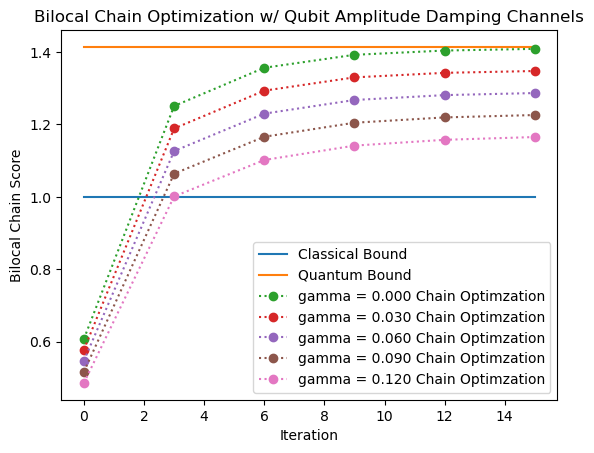

In [8]:
samples = phase_damp_bilocal_opt_dicts[0]["samples"]

plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2/np.sqrt(2)]*len(samples), label = "Quantum Bound")

id = 0
gammas = np.arange(0,0.121,0.03)
for opt_dict in phase_damp_bilocal_opt_dicts:
    plt.plot(samples, opt_dict["scores"], "o:", label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.title(r"Bilocal Chain Optimization w/ Qubit Amplitude Damping Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Score")
plt.legend()
plt.show()